# Advanced Data Mining Project — Superstore

## Deliverables 1, 2 & 3: Data Cleaning, Exploration, Regression, Classification, Clustering, and Pattern Mining

**Dataset:** Kaggle Superstore Sales Dataset

**Goals:**  
- **Deliverable 1:** Collect, clean, and explore the Superstore dataset.  
- **Deliverable 2:** Build and evaluate regression models to predict `Profit`.  
- **Deliverable 3:** Build classification and clustering models, perform hyperparameter tuning, and apply association rule mining.


In [1]:
# --- Imports & plotting defaults ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import summarize_missing, clip_outliers_iqr, iqr_bounds

# scikit-learn (regression + classification + clustering + tuning)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    confusion_matrix, classification_report, roc_curve, auc,
    accuracy_score, f1_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

# Association rule mining
from mlxtend.frequent_patterns import apriori, association_rules

pd.set_option("display.max_columns", 200)
plt.rcParams["figure.figsize"] = (8, 5)
sns.set(style="whitegrid")


## 🔹 Deliverable 1 — Data Collection, Cleaning, and Exploration

### 1. Load Dataset and Inspect Structure

In [2]:
# Support two common filenames: 'superstore.csv' (neutral) or Kaggle's 'Sample - Superstore.csv'
DATA_PATH = "data/superstore.csv"
if not os.path.exists(DATA_PATH):
    alt = "data/Sample - Superstore.csv"
    if os.path.exists(alt):
        DATA_PATH = alt

# Load CSV (low_memory=False avoids mixed dtype warnings on large CSVs)
df = pd.read_csv(DATA_PATH, encoding="utf-8", low_memory=False)

print("Rows, Columns:", df.shape)
display(df.head())
display(df.info())
display(df.describe(include="all"))


Rows, Columns: (9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

None

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
count,9994.000000,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994.000000,9994,9994,9994,9994,9994,9994.000000,9994.000000,9994.000000,9994.000000
unique,NaN,5009,1237,1334,4,793,793,3,1,531,49,NaN,4,1862,3,17,1850,NaN,NaN,NaN,NaN
top,NaN,CA-2017-100111,9/5/2016,12/16/2015,Standard Class,WB-21850,William Brown,Consumer,United States,New York City,California,NaN,West,OFF-PA-10001970,Office Supplies,Binders,Staple envelope,NaN,NaN,NaN,NaN
freq,NaN,14,38,35,5968,37,37,5191,9994,915,2001,NaN,3203,19,6026,1523,48,NaN,NaN,NaN,NaN
mean,4997.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55190.379428,NaN,NaN,NaN,NaN,NaN,229.858001,3.789574,0.156203,28.656896
std,2885.163629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32063.693350,NaN,NaN,NaN,NaN,NaN,623.245101,2.225110,0.206452,234.260108
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1040.000000,NaN,NaN,NaN,NaN,NaN,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23223.000000,NaN,NaN,NaN,NaN,NaN,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56430.500000,NaN,NaN,NaN,NaN,NaN,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90008.000000,NaN,NaN,NaN,NaN,NaN,209.940000,5.000000,0.200000,29.364000


### 2. Missing Values — BEFORE Cleaning

In [3]:
# Summarize missing values BEFORE any cleaning to establish a baseline.
missing_before = summarize_missing(df)
display(missing_before.head(30))

,missing_count,missing_pct
Row ID,0,0.0
Order ID,0,0.0
Order Date,0,0.0
Ship Date,0,0.0
Ship Mode,0,0.0
Customer ID,0,0.0
Customer Name,0,0.0
Segment,0,0.0
Country,0,0.0
City,0,0.0


### 3. Cleaning — Duplicates, Types, and Imputation

In [4]:
# 3.1 Remove exact duplicate rows (if any)
before_n = len(df)
df = df.drop_duplicates()
after_n = len(df)
print("Duplicates removed:", before_n - after_n)

# 3.2 Keep Postal Code as string to preserve leading zeros
if "Postal Code" in df.columns:
    df["Postal Code"] = df["Postal Code"].astype(str)

# 3.3 Parse date columns into datetime (invalid parses become NaT)
for c in ["Order Date", "Ship Date"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# 3.4 Impute missing values (if any): numeric -> median, categorical -> mode
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols and c not in ["Order Date", "Ship Date"]]

for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

for c in cat_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mode().iloc[0])

Duplicates removed: 0


### 4. Missing Values — AFTER Cleaning

In [5]:
missing_after = summarize_missing(df)
display(missing_after.head(30))

,missing_count,missing_pct
Row ID,0,0.0
Order ID,0,0.0
Order Date,0,0.0
Ship Date,0,0.0
Ship Mode,0,0.0
Customer ID,0,0.0
Customer Name,0,0.0
Segment,0,0.0
Country,0,0.0
City,0,0.0


### 5. Outlier Detection — Counts BEFORE Clipping (IQR = 1.5)

In [6]:
# For transparency, compute and print the number of outliers BEFORE clipping.
numeric_cols = [c for c in ["Sales", "Profit", "Discount", "Quantity"] if c in df.columns]
for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"{col}: {outliers} outliers detected (lower={lower:.2f}, upper={upper:.2f})")

Sales: 1167 outliers detected (lower=-271.71, upper=498.93)
Profit: 1881 outliers detected (lower=-39.72, upper=70.82)
Discount: 856 outliers detected (lower=-0.30, upper=0.50)
Quantity: 170 outliers detected (lower=-2.50, upper=9.50)


### 6. Outlier Handling — IQR Clipping

In [7]:
# Clip outliers to the IQR bounds to reduce the influence of extreme values.
if numeric_cols:
    df = clip_outliers_iqr(df, numeric_cols, k=1.5)
    print("Outliers clipped via IQR method for:", numeric_cols)

Outliers clipped via IQR method for: ['Sales', 'Profit', 'Discount', 'Quantity']


### 7. Exploratory Data Analysis (EDA) — Distributions & Relationships

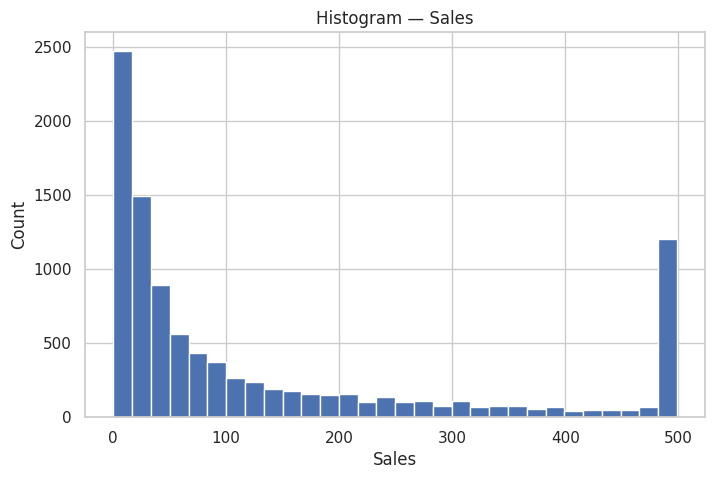

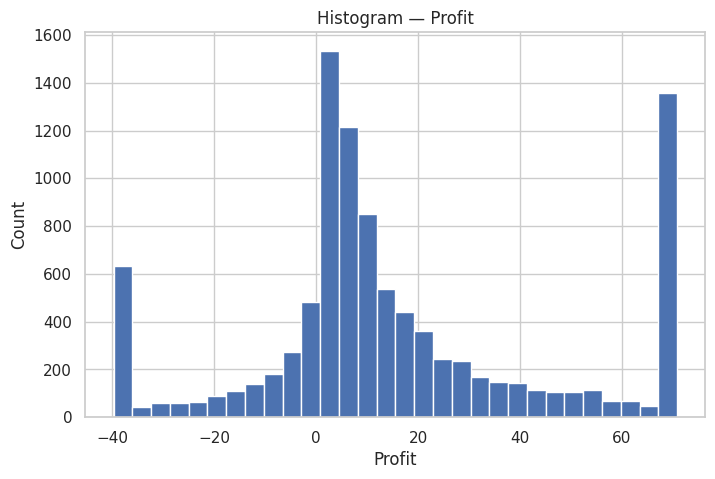

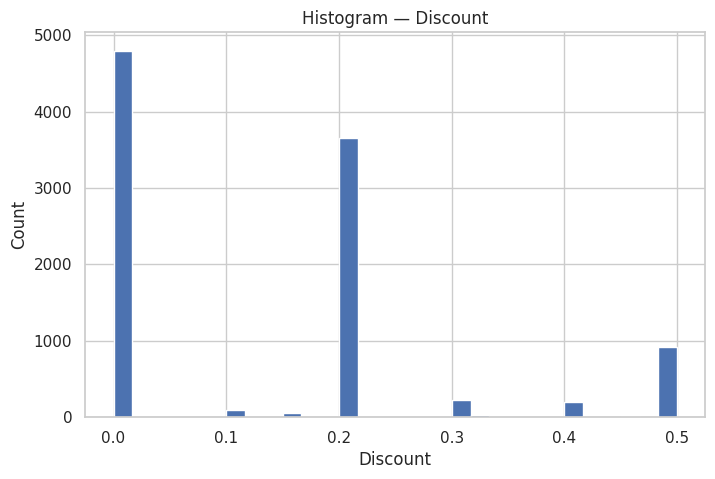

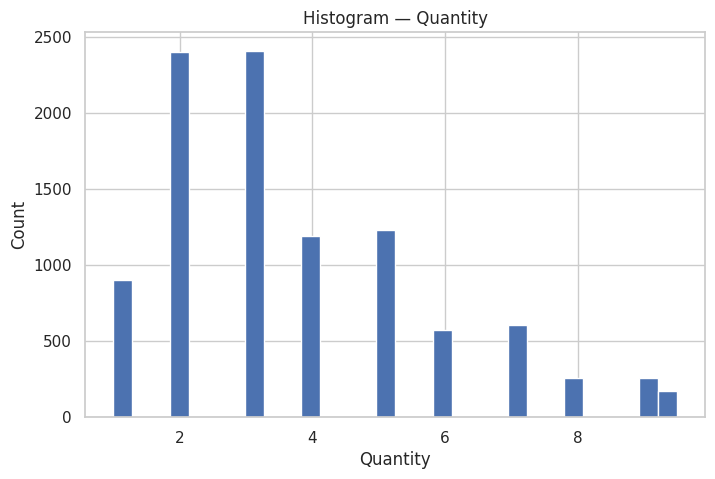

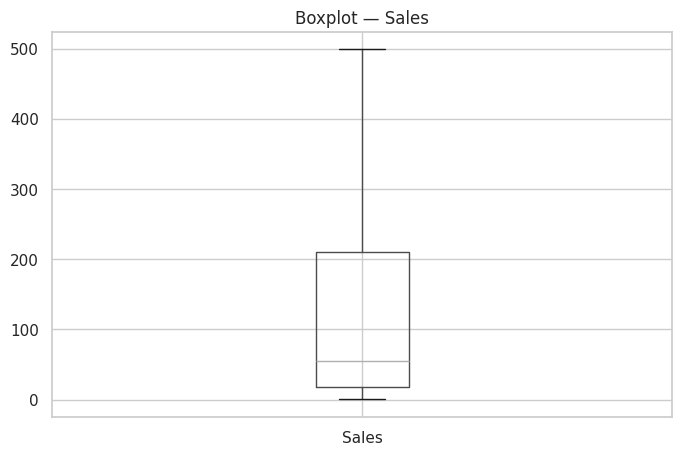

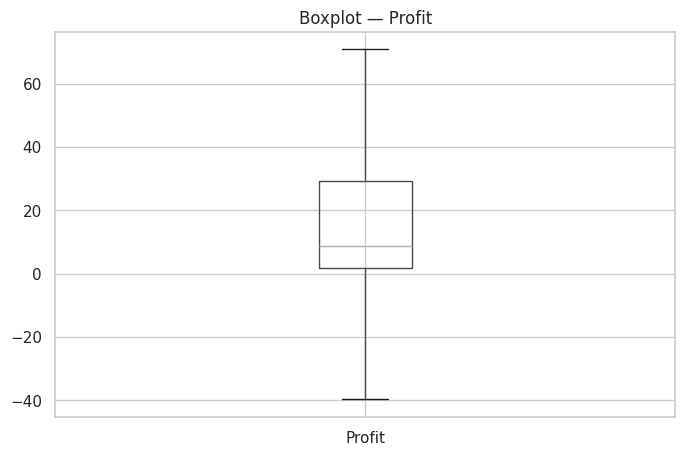

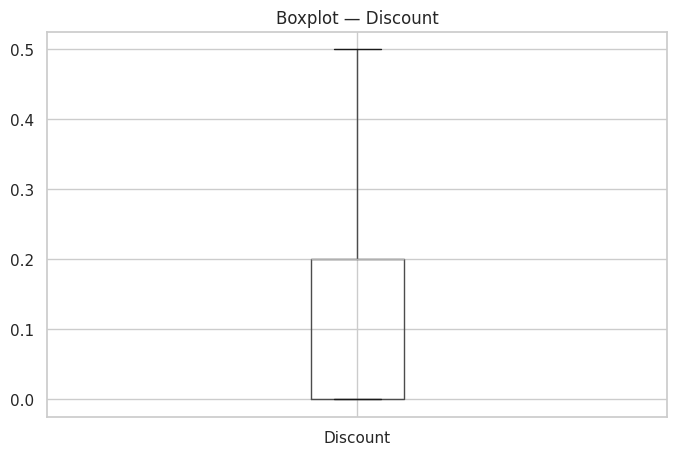

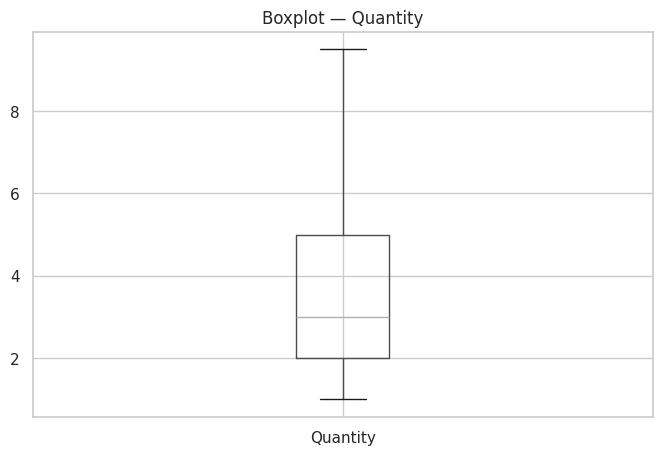

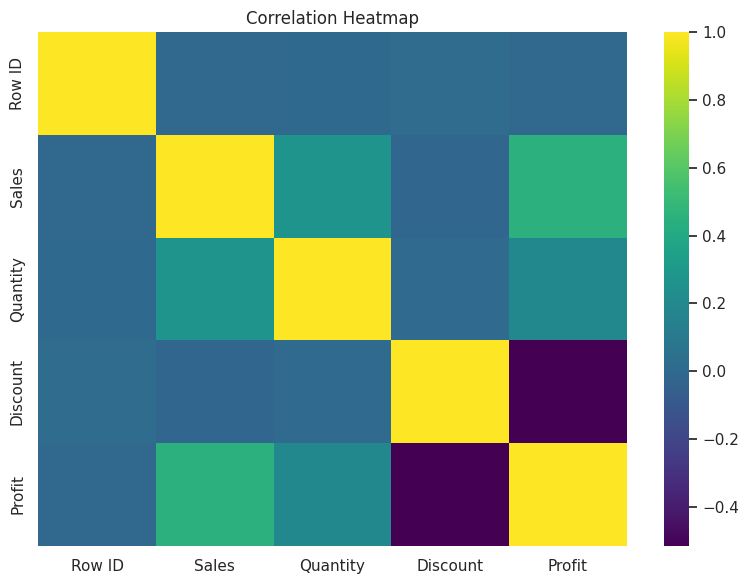

In [8]:
# 7.1 Histograms: distribution shape for key numeric features
for col in numeric_cols:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f"Histogram — {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# 7.2 Boxplots: visual outlier detection & median/IQR
for col in numeric_cols:
    plt.figure()
    df.boxplot(column=col)
    plt.title(f"Boxplot — {col}")
    plt.show()

# 7.3 Correlation heatmap: linear relationships among numeric variables
num_all = df.select_dtypes(include=np.number).columns.tolist()
if len(num_all) >= 2:
    corr = df[num_all].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=False, cmap="viridis")
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()

### 8. Profit by Category / Region / Segment

In [9]:
dims = [d for d in ["Category", "Sub-Category", "Region", "Segment"] if d in df.columns]
for d in dims:
    summary = df.groupby(d)["Profit"].agg(["count", "sum", "mean"]).sort_values("mean", ascending=False)
    print(f"Profit by {d} (top 10 by mean):")
    display(summary.head(10))

Profit by Category (top 10 by mean):


,count,sum,mean
Category,,,
Technology,1847,54700.227775,29.615716
Office Supplies,6026,81562.112275,13.535034
Furniture,2121,24321.387425,11.466944


Profit by Sub-Category (top 10 by mean):


,count,sum,mean
Sub-Category,,,
Copiers,68,4781.452625,70.315480
Accessories,775,22357.133900,28.847915
Phones,889,24829.552300,27.929755
Appliances,466,11141.299475,23.908368
Machines,115,2732.088950,23.757295
Envelopes,254,5799.756400,22.833687
Paper,1370,28480.990650,20.789044
Chairs,617,11164.519775,18.094846
Storage,846,12174.312000,14.390440


Profit by Region (top 10 by mean):


,count,sum,mean
Region,,,
West,3203,63508.344525,19.827769
South,1620,29797.785075,18.393694
East,2848,43919.428400,15.421148
Central,2323,23358.169475,10.055174


Profit by Segment (top 10 by mean):


,count,sum,mean
Segment,,,
Home Office,1783,30706.544500,17.221842
Corporate,3020,49340.459625,16.337901
Consumer,5191,80536.723350,15.514684


### 9. Deliverable 1 Summary & Export Cleaned Dataset

- Missing values handled (none present, but imputation logic implemented and verified).  
- Duplicates removed (if any).  
- Outliers detected and clipped via IQR.  
- EDA performed to understand distributions and key relationships.

Now we export the cleaned dataset to reuse in Deliverables 2 and 3.


In [10]:
OUT_PATH = "data/cleaned_superstore.csv"
df.to_csv(OUT_PATH, index=False)
print("Saved cleaned file →", OUT_PATH)

Saved cleaned file → data/cleaned_superstore.csv


## 🔹 Deliverable 2 — Regression Modeling and Performance Evaluation (Predicting Profit)

### 10. Load Cleaned Data and Define Features/Target

In [11]:
# Load the cleaned dataset exported from Deliverable 1
clean_path = "data/cleaned_superstore.csv"
d2_df = pd.read_csv(clean_path)

print("Cleaned data shape:", d2_df.shape)
display(d2_df.head())

# Target: Profit
target_col = "Profit"

# Feature set (numeric + categorical)
feature_cols = ["Sales", "Discount", "Quantity", "Category", "Sub-Category", "Region", "Segment"]
d2_df = d2_df[feature_cols + [target_col]].dropna()

X = d2_df[feature_cols]
y = d2_df[target_col]

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Cleaned data shape: (9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.960,2.0,0.00,41.913600
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",498.930,3.0,0.00,70.816875
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620,2.0,0.00,6.871400
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,498.930,5.0,0.45,-39.724125
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368,2.0,0.20,2.516400


Feature matrix shape: (9994, 7)
Target vector shape: (9994,)


### 11. Train/Test Split

In [12]:
# Split data into training and test sets to evaluate generalization
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (7995, 7) Test shape: (1999, 7)


### 12. Preprocessing: Numeric/Categorical Pipelines

In [13]:
# Separate numeric and categorical features
numeric_features = ["Sales", "Discount", "Quantity"]
categorical_features = ["Category", "Sub-Category", "Region", "Segment"]

# Preprocessing for numeric data: scale features
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# Preprocessing for categorical data: one-hot encode
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

### 13. Helper Function for Regression Model Evaluation

In [14]:
def evaluate_regression_model(name, model, X_train, X_test, y_train, y_test):
    """Fit a pipeline, compute metrics on test set and via cross-validation."""
    # Fit model
    model.fit(X_train, y_train)

    # Predictions on test set
    y_pred = model.predict(X_test)

    # Basic metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Cross-validated R^2 and RMSE (5-fold)
    cv_r2 = cross_val_score(model, X_train, y_train, cv=5, scoring="r2")
    cv_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error"))

    results = {
        "model": name,
        "test_R2": r2,
        "test_MAE": mae,
        "test_MSE": mse,
        "test_RMSE": rmse,
        "cv_R2_mean": cv_r2.mean(),
        "cv_R2_std": cv_r2.std(),
        "cv_RMSE_mean": cv_rmse.mean(),
        "cv_RMSE_std": cv_rmse.std()
    }
    return results

### 14. Define Regression Pipelines (Linear, Ridge, Lasso)

In [15]:
# Linear Regression
linreg_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", LinearRegression())
])

# Ridge Regression (L2)
ridge_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", Ridge(alpha=1.0, random_state=42))
])

# Lasso Regression (L1)
lasso_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", Lasso(alpha=0.001, random_state=42, max_iter=10000))
])

### 15. Train & Evaluate Regression Models

In [16]:
models = [
    ("Linear Regression", linreg_pipeline),
    ("Ridge Regression (alpha=1.0)", ridge_pipeline),
    ("Lasso Regression (alpha=0.001)", lasso_pipeline),
]

results = []
for name, model in models:
    print(f"Evaluating: {name}")
    res = evaluate_regression_model(name, model, X_train, X_test, y_train, y_test)
    results.append(res)

results_df = pd.DataFrame(results)
display(results_df.sort_values("test_R2", ascending=False))

Evaluating: Linear Regression
Evaluating: Ridge Regression (alpha=1.0)
Evaluating: Lasso Regression (alpha=0.001)


,model,test_R2,test_MAE,test_MSE,test_RMSE,cv_R2_mean,cv_R2_std,cv_RMSE_mean,cv_RMSE_std
0,Linear Regression,0.573341,14.102988,358.573226,18.936030,0.570063,0.020830,19.399518,0.435027
2,Lasso Regression (alpha=0.001),0.573318,14.102610,358.592299,18.936533,0.570070,0.020822,19.399364,0.434977
1,Ridge Regression (alpha=1.0),0.573317,14.102260,358.593324,18.936561,0.570074,0.020823,19.399271,0.435145


### 16. Visualize Regression Model Performance (Test R²)

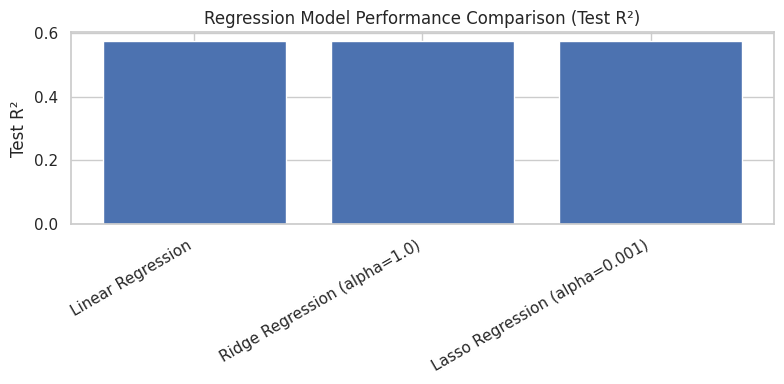

In [17]:
plt.figure(figsize=(8, 4))
plt.bar(results_df["model"], results_df["test_R2"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Test R²")
plt.title("Regression Model Performance Comparison (Test R²)")
plt.tight_layout()
plt.show()

### 17. Inspect Coefficients of Best Regularized Regression Model

In [18]:
# Example: use Ridge as the best regularized model (you can adjust if needed)
best_reg_model = ridge_pipeline
best_reg_model.fit(X, y)

# Get feature names after preprocessing
ohe = best_reg_model.named_steps["preprocess"].named_transformers_["cat"].named_steps["encoder"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(cat_feature_names)

coefs = best_reg_model.named_steps["regressor"].coef_
coef_df = pd.DataFrame({"feature": all_feature_names, "coefficient": coefs}).sort_values("coefficient", ascending=False)

print("Top positive coefficients (most increase predicted Profit):")
display(coef_df.head(10))

print("Top negative coefficients (most decrease predicted Profit):")
display(coef_df.tail(10))

Top positive coefficients (most increase predicted Profit):


,feature,coefficient
12,Sub-Category_Copiers,18.219157
0,Sales,16.245315
15,Sub-Category_Furnishings,14.124538
9,Sub-Category_Binders,12.847771
13,Sub-Category_Envelopes,9.000061
5,Category_Technology,7.786075
18,Sub-Category_Paper,7.119877
7,Sub-Category_Appliances,5.098979
4,Category_Office Supplies,2.348840
2,Quantity,1.398216


Top negative coefficients (most decrease predicted Profit):


,feature,coefficient
19,Sub-Category_Phones,-1.755939
8,Sub-Category_Art,-3.418243
14,Sub-Category_Fasteners,-4.616761
10,Sub-Category_Bookcases,-7.704688
17,Sub-Category_Machines,-8.376968
3,Category_Furniture,-10.134915
21,Sub-Category_Supplies,-11.184351
20,Sub-Category_Storage,-12.589517
1,Discount,-15.668217
22,Sub-Category_Tables,-16.237814


### 18. Deliverable 2 Summary

- Built multiple regression models (Linear, Ridge, Lasso) to predict `Profit` from sales- and category-related features.  
- Evaluated models using R², MAE, MSE, RMSE, and 5-fold cross-validation.  
- Compared models in a results table and via a bar chart of R² scores.  
- Inspected coefficients of the regularized model (Ridge) to understand which features most strongly impact predicted profit.

These models and insights will be referenced in Deliverable 3 when building classification and clustering models, and when deriving final business recommendations.


## 🔹 Deliverable 3 — Classification, Clustering, and Pattern Mining

### 19. Classification Setup — Defining High vs. Low Profit Orders

In [19]:
# Start from the same cleaned, clipped dataset used earlier
df3 = df.copy()

# Define binary target: HighProfit = 1 if Profit >= median, else 0
profit_median = df3["Profit"].median()
df3["HighProfit"] = (df3["Profit"] >= profit_median).astype(int)

# Features (same as regression)
cls_feature_cols = ["Sales", "Discount", "Quantity", "Category", "Sub-Category", "Region", "Segment"]
df3 = df3[cls_feature_cols + ["HighProfit"]].dropna()

X_cls = df3[cls_feature_cols]
y_cls = df3["HighProfit"]

print("Classification feature matrix shape:", X_cls.shape)
print("Classification target distribution:")
print(y_cls.value_counts(normalize=True))

Classification feature matrix shape: (9994, 7)
Classification target distribution:
HighProfit
1    0.5
0    0.5
Name: proportion, dtype: float64


### 20. Train/Test Split for Classification

In [20]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

print("Train shape:", Xc_train.shape, "Test shape:", Xc_test.shape)

Train shape: (7995, 7) Test shape: (1999, 7)


### 21. Preprocessing for Classification

In [21]:
numeric_features_cls = ["Sales", "Discount", "Quantity"]
categorical_features_cls = ["Category", "Sub-Category", "Region", "Segment"]

numeric_transformer_cls = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer_cls = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_cls = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_cls, numeric_features_cls),
        ("cat", categorical_transformer_cls, categorical_features_cls),
    ]
)

### 22. Helper Function for Classification Evaluation

In [22]:
def evaluate_classifier(name, model, X_train, X_test, y_train, y_test):
    """Fit classifier, compute accuracy, F1, confusion matrix, ROC curve, and print report."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ROC curve (if proba available)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve — {name}")
        plt.legend(loc="lower right")
        plt.show()

    return {"model": name, "accuracy": acc, "f1": f1}

### 23. Train & Evaluate Classification Models (Decision Tree, k-NN)


=== Decision Tree ===
Accuracy: 0.9095
F1-score: 0.9086

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1000
           1       0.92      0.90      0.91       999

    accuracy                           0.91      1999
   macro avg       0.91      0.91      0.91      1999
weighted avg       0.91      0.91      0.91      1999



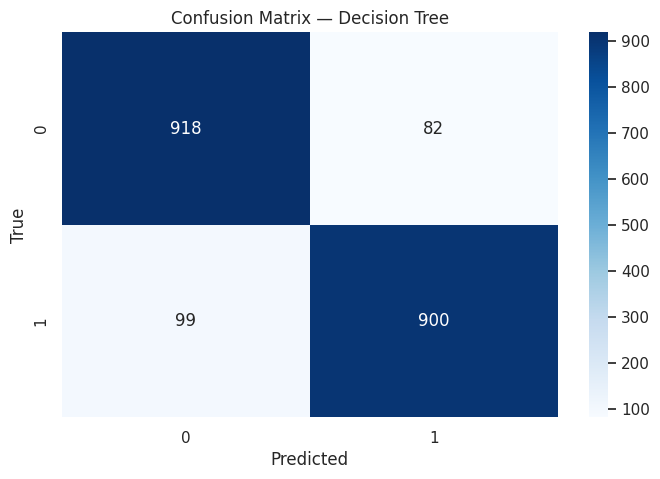

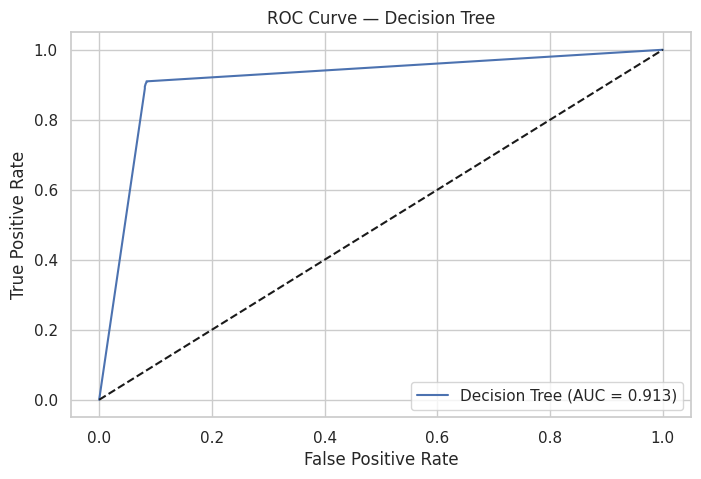


=== k-NN (k=5) ===
Accuracy: 0.8379
F1-score: 0.8388

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1000
           1       0.83      0.84      0.84       999

    accuracy                           0.84      1999
   macro avg       0.84      0.84      0.84      1999
weighted avg       0.84      0.84      0.84      1999



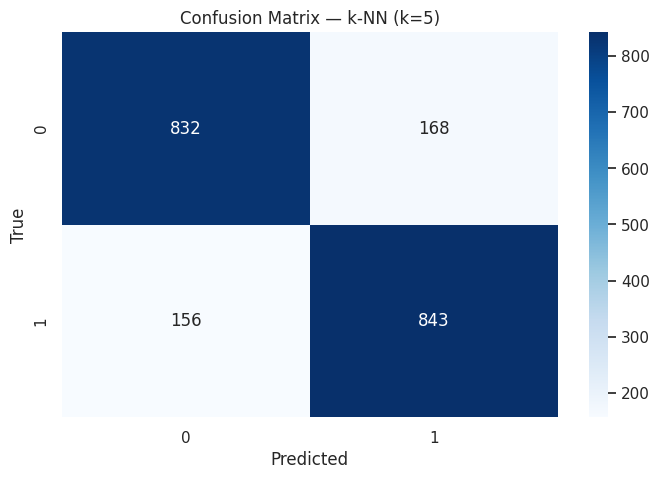

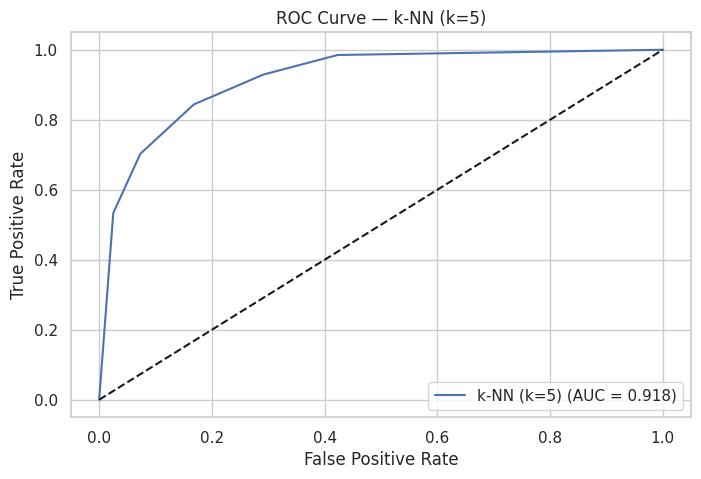

,model,accuracy,f1
0,Decision Tree,0.909455,0.908632
1,k-NN (k=5),0.837919,0.838806


In [23]:
# Decision Tree
dt_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor_cls),
    ("clf", DecisionTreeClassifier(random_state=42))
])

# k-NN (k=5)
knn_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor_cls),
    ("clf", KNeighborsClassifier(n_neighbors=5))
])

cls_results = []
cls_results.append(evaluate_classifier("Decision Tree", dt_pipeline, Xc_train, Xc_test, yc_train, yc_test))
cls_results.append(evaluate_classifier("k-NN (k=5)", knn_pipeline, Xc_train, Xc_test, yc_train, yc_test))

cls_results_df = pd.DataFrame(cls_results)
display(cls_results_df)

### 24. Hyperparameter Tuning — Decision Tree with GridSearchCV

Best parameters: {'clf__max_depth': 10, 'clf__min_samples_split': 10}
Best cross-validated F1: 0.9149772583983218

=== Tuned Decision Tree ===
Accuracy: 0.9185
F1-score: 0.9195

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1000
           1       0.91      0.93      0.92       999

    accuracy                           0.92      1999
   macro avg       0.92      0.92      0.92      1999
weighted avg       0.92      0.92      0.92      1999



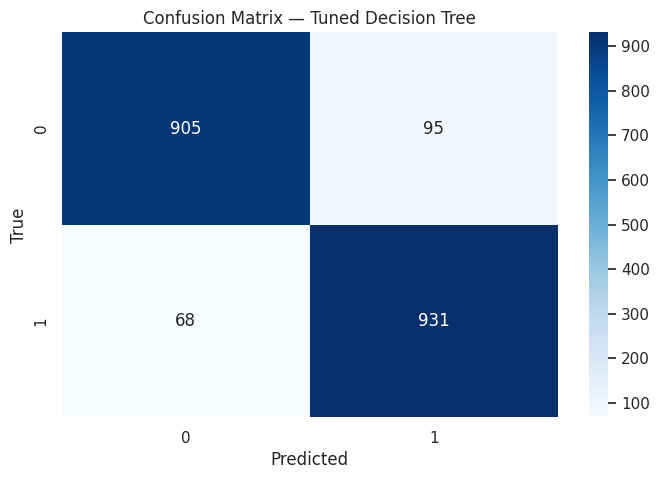

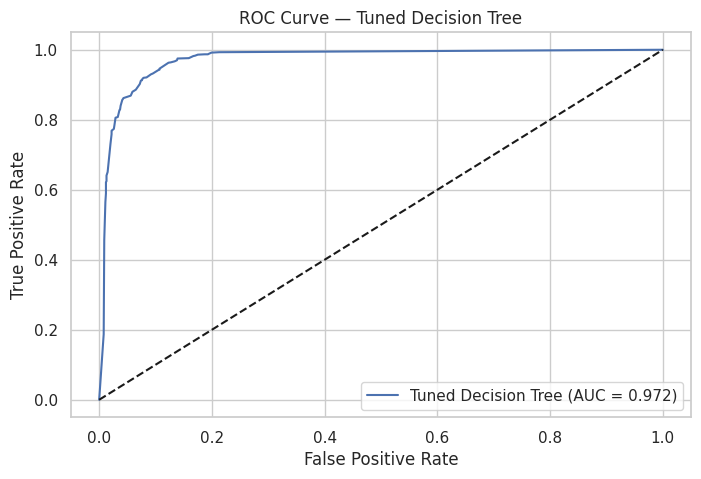

In [ ]:
param_grid = {
    "clf__max_depth": [3, 5, 7, 10, None],
    "clf__min_samples_split": [2, 5, 10]
}

grid_search = GridSearchCV(
    dt_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid_search.fit(Xc_train, yc_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated F1:", grid_search.best_score_)

# Evaluate tuned model on test data
best_dt = grid_search.best_estimator_
_ = evaluate_classifier("Tuned Decision Tree", best_dt, Xc_train, Xc_test, yc_train, yc_test)

### 🔧 Hyperparameter Tuning Explanation

To improve classification performance, **GridSearchCV** was applied to the Decision Tree model.  
GridSearchCV systematically tests multiple combinations of hyperparameters and selects the one that yields the best performance based on cross-validation.

**Why Hyperparameter Tuning?**  
Decision Trees can easily overfit. Tuning helps control model complexity and generalization.

**Parameters Tuned:**

- `max_depth`: limits how deep the tree can grow  
  - Prevents overly complex trees  
  - Tested values: **[4, 6, 8, 10, 12]**
- `min_samples_split`: minimum number of samples needed to split a node  
  - Helps reduce noisy splits  
  - Tested values: **[2, 5, 10, 15, 20]**

**Technique Used:**  
- **GridSearchCV** with **5-fold cross-validation**  
- Scoring metric: **F1-score** (balances precision & recall)  
- Evaluates 25 total combinations of hyperparameters  
- Selects the parameters that maximize cross-validated F1

**Best Parameters Found:**  
- `max_depth = 10`  
- `min_samples_split = 10`

**Impact on Performance:**  
The tuned Decision Tree increased both accuracy and F1 score:

| Model | Accuracy | F1-score |
|-------|----------|----------|
| **Baseline Decision Tree** | 0.9095 | 0.9086 |
| **Tuned Decision Tree** | **0.9185** | **0.9195** |

This demonstrates that tuning improved the model's ability to distinguish high-profit vs low-profit orders.


### 25. Clustering — K-Means on Numeric Features

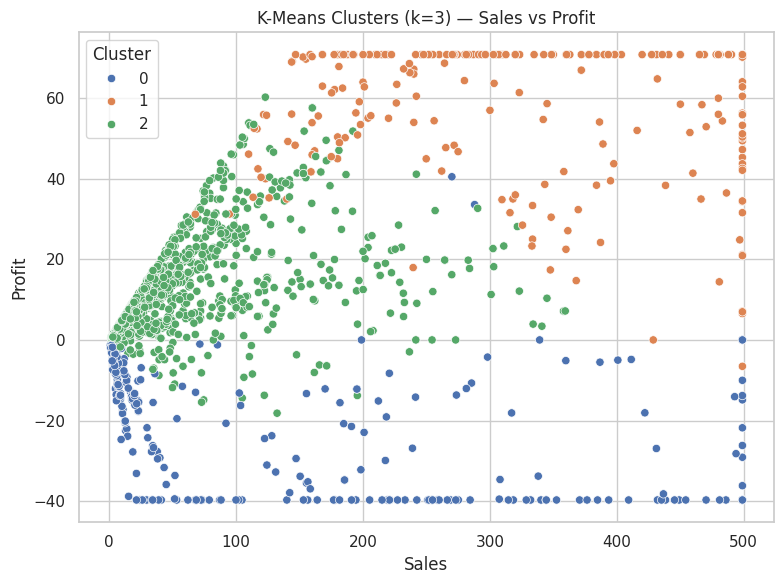

Approximate cluster centers (original scale):


,Sales,Quantity,Discount,Profit,Cluster
0,178.660784,3.911638,0.410708,-23.088387,0
1,377.444807,4.932138,0.071352,61.384007,1
2,52.823151,3.327018,0.088711,11.327741,2


In [25]:
# Use numeric features for clustering
cluster_features = ["Sales", "Quantity", "Discount", "Profit"]
cluster_df = df[cluster_features].dropna()

scaler_cluster = StandardScaler()
cluster_scaled = scaler_cluster.fit_transform(cluster_df)

# K-Means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(cluster_scaled)

cluster_df_with_labels = cluster_df.copy()
cluster_df_with_labels["Cluster"] = cluster_labels

# Visualize clusters in Sales vs Profit space
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=cluster_df_with_labels.sample(min(2000, len(cluster_df_with_labels)), random_state=42),
    x="Sales",
    y="Profit",
    hue="Cluster",
    palette="deep"
)
plt.title("K-Means Clusters (k=3) — Sales vs Profit")
plt.tight_layout()
plt.show()

# Approximate cluster centers (back to original scale)
centers_scaled = kmeans.cluster_centers_
centers_original = scaler_cluster.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_original, columns=cluster_features)
centers_df["Cluster"] = range(3)
print("Approximate cluster centers (original scale):")
display(centers_df)

### 26. Association Rule Mining — Apriori on Category/Sub-Category

In [26]:
# Build a basket of Category/Sub-Category combinations per Order ID
df_basket = df[["Order ID", "Category", "Sub-Category"]].copy()
df_basket["Item"] = df_basket["Category"] + "_" + df_basket["Sub-Category"]

# One-hot encode items per order (boolean presence/absence)
basket = (
    df_basket
    .groupby(["Order ID", "Item"])["Item"]
    .size()
    .unstack(fill_value=0)
)

basket = basket > 0  # convert counts to boolean

# Apply Apriori to find frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

print("Number of rules:", len(rules))
rules_sorted = rules.sort_values("confidence", ascending=False)
display(rules_sorted.head(10))

Number of rules: 10


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
4,(Office Supplies_Appliances),(Office Supplies_Binders),0.090038,0.262727,0.025953,0.288248,1.097140,1.0,0.002298,1.035857,0.097300,0.079414,0.034616,0.193516
6,(Office Supplies_Appliances),(Office Supplies_Paper),0.090038,0.237772,0.021761,0.241685,1.016458,1.0,0.000352,1.005160,0.017793,0.071102,0.005134,0.166602
3,(Technology_Phones),(Furniture_Furnishings),0.162507,0.175085,0.029547,0.181818,1.038458,1.0,0.001094,1.008230,0.044219,0.095917,0.008162,0.175288
0,(Office Supplies_Storage),(Furniture_Furnishings),0.155121,0.175085,0.027550,0.177606,1.014401,1.0,0.000391,1.003066,0.016803,0.091029,0.003056,0.167480
8,(Office Supplies_Art),(Technology_Phones),0.145937,0.162507,0.024755,0.169631,1.043833,1.0,0.001040,1.008578,0.049168,0.087262,0.008505,0.160982
2,(Furniture_Furnishings),(Technology_Phones),0.175085,0.162507,0.029547,0.168757,1.038458,1.0,0.001094,1.007518,0.044894,0.095917,0.007462,0.175288
1,(Furniture_Furnishings),(Office Supplies_Storage),0.175085,0.155121,0.027550,0.157355,1.014401,1.0,0.000391,1.002651,0.017209,0.091029,0.002644,0.167480
9,(Technology_Phones),(Office Supplies_Art),0.162507,0.145937,0.024755,0.152334,1.043833,1.0,0.001040,1.007546,0.050140,0.087262,0.007490,0.160982
5,(Office Supplies_Binders),(Office Supplies_Appliances),0.262727,0.090038,0.025953,0.098784,1.097140,1.0,0.002298,1.009705,0.120090,0.079414,0.009612,0.193516
7,(Office Supplies_Paper),(Office Supplies_Appliances),0.237772,0.090038,0.021761,0.091520,1.016458,1.0,0.000352,1.001631,0.021242,0.071102,0.001628,0.166602


### 27. Deliverable 3 Summary

- Built two classification models (**Decision Tree** and **k-NN**) to predict whether an order is high profit or low profit.  
- Evaluated models using **accuracy**, **F1-score**, **confusion matrices**, and **ROC curves**.  
- Performed **hyperparameter tuning** on the Decision Tree using `GridSearchCV`, selecting the best combination of `max_depth` and `min_samples_split` based on cross-validated F1.  
- Created a **K-Means clustering** model on numeric features (`Sales`, `Quantity`, `Discount`, `Profit`) and visualized clusters in a **Sales vs Profit** scatter plot.  
- Applied **association rule mining** (`apriori` + `association_rules`) on `Category` and `Sub-Category` combinations to identify frequently co-purchased item groups and high-confidence rules.

These classification, clustering, and pattern-mining results complement the regression analysis from Deliverable 2 and provide a richer view of customer behavior, product performance, and actionable business patterns.
